In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('drive/MyDrive/NLP_Project/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

drive/MyDrive/NLP_Project/archive/twitter_training.csv
drive/MyDrive/NLP_Project/archive/twitter_validation.csv


In [9]:
import torch
import re
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
test_df = pd.read_csv('drive/MyDrive/NLP_Project/archive/twitter_validation.csv', header=None)
train_df = pd.read_csv('drive/MyDrive/NLP_Project/archive/twitter_training.csv', header=None)

test_df.reset_index(drop=True,inplace=True)
train_df.reset_index(drop=True,inplace=True)

df = pd.concat([train_df,test_df], axis=0)
df.drop([0], axis=1, inplace=True)
df.columns = ['platform','sentiment','text']

In [5]:
df.drop(['platform'], axis=1, inplace=True)
df.sentiment = df.sentiment.map({"Neutral":0, "Irrelevant":0 ,"Positive":1,"Negative":2})
df.dropna(inplace=True)

In [6]:
def clean_text(text):
    if isinstance(text, str):
        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove special characters
        str_text = re.sub(r'[^\w\s]', '', text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = str_text.lower().split()
        str_text = ' '.join([word for word in tokens if word not in stop_words])
        return str_text
    else:
        return text

In [10]:
df["text"] = df['text'].apply(clean_text)

In [11]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = df.sentiment.values)

In [14]:
import gc
del df
gc.collect()

168

In [16]:
train_df

,sentiment,text
70076,1,cool time
36075,1,thank kevin peesker president unk
754,0,wine drunk playing new borderlands goddess lif...
35258,2,says microsofts hardware software security man...
46661,1,home depots ghoulish yellowbones line become o...
...,...,...
19098,1,oh fucking yeah im adalid
45297,1,faster lives lives preserved cool see verizon ...
15769,0,happy admiralbulldog legendary day legendary e...
5074,0,played interesting quiz amazon try luck enough...


In [17]:
encoder_train = tokenizer.batch_encode_plus(train_df.text.values,
                                           add_special_tokens = True,
                                            return_attention_mask = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(test_df.text.values,
                                           add_special_tokens = True,
                                            return_attention_mask = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(train_df.sentiment.values)


input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(test_df.sentiment.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

In [19]:
len(data_train),len(data_test)

(59996, 15000)

In [20]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = 3,
                                     output_attentions = False,
                                     output_hidden_states =  False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader
dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16

)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32

)

In [22]:
from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)

epochs = 5
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
from sklearn.metrics import f1_score, accuracy_score

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')

def acc(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [24]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")
model

Loading:cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:
def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions,true_vals = [],[]

    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)


    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals


In [29]:
epochs = 1
training_loss = []
validation_loss = []
testScore = []
test_acc = []
for epoch in tqdm(range(1,epochs+1)):
    model.train()

    loss_train_total=0

    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)


    for batch in progress_bar:
        train_acc = 0.0
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]

        }
        outputs = model(**inputs)

        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)

        optimizer.step()
        scheduler.step()


        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write(f'Epoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    training_loss.append(loss_train_avg)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    test_accuracy = acc(predictions, true_vals)
    validation_loss.append(val_loss)
    testScore.append(test_score)
    test_acc.append(test_accuracy)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score} \n Test Accuracy:{test_accuracy}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-29-0e5bb0018528>:32: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Epoch 1
Training Loss: 0.5748121350198984


  0%|          | 0/469 [00:00<?, ?it/s]

Val Loss:0.385188183471211
 Test Score:0.8543795133798936 
 Test Accuracy:0.8544


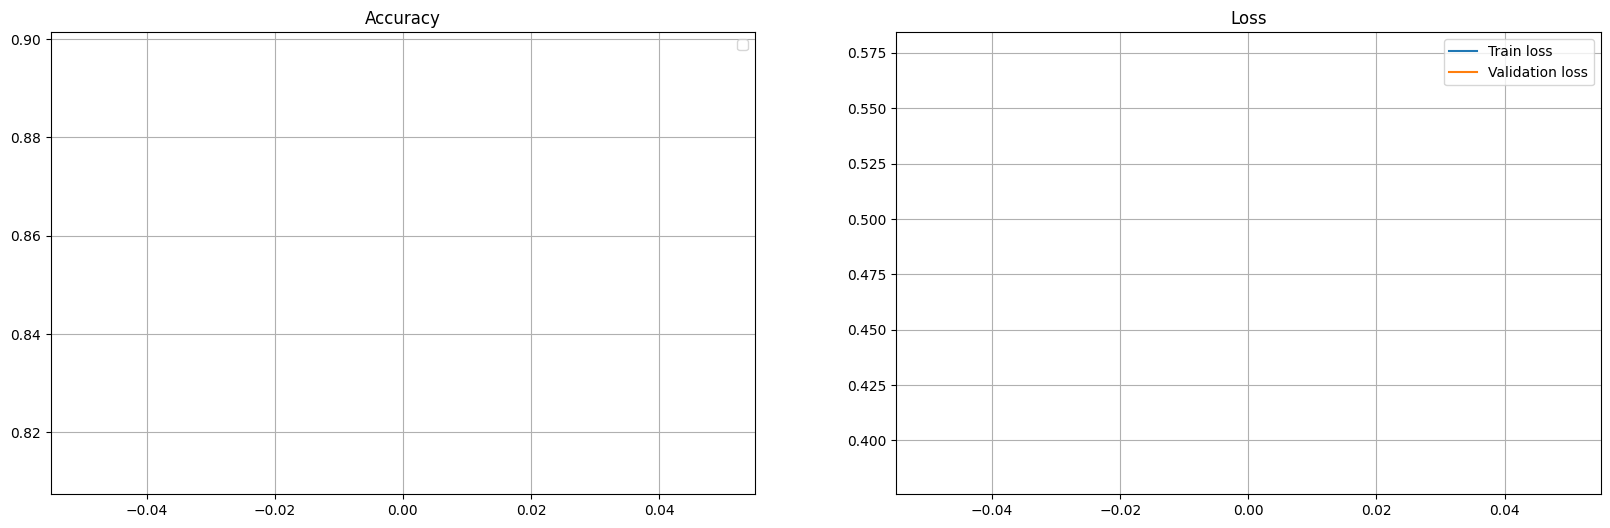

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(test_acc)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()